In [1]:
# Load python modules
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
import seaborn as sn
import tensorflow_datasets as tfds
from sklearn.utils import shuffle 
import matplotlib.pyplot as plt
from datetime import datetime
import tensorflow as tf
from tqdm import tqdm  # Perform iterature with progress bar
import numpy as np
import PIL.Image
import PIL
import cv2
import os


In [2]:
#Class labelsb
class_names = ['Glass', 'Metal', 'Paper', 'Textile']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}
nb_classes = len(class_names)
image_size = (128, 128)

In [3]:
print('Number of classes:', nb_classes)

Number of classes: 4


In [4]:
def load_data():
    """
        Load the data from local folder
        
    """
    datasets = ['C:/Mani/Dataset/dataset1/train_ds',
               'C:/Mani/Dataset/dataset1/test_ds']
    
    
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, image_size) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [5]:
#Prepare dataset for training and testing
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading C:/Mani/Dataset/dataset1/train_ds


100%|███████████████████████████████████████████████████████████████████████████████| 270/270 [00:01<00:00, 188.51it/s]


Loading C:/Mani/Dataset/dataset1/test_ds


100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 187.26it/s]


In [6]:
#Check the training and testing image shape
train_images.shape, test_images.shape

((1080, 128, 128, 3), (200, 128, 128, 3))

In [7]:
# Shuffle only the training dataset
np.random.seed(321)
train_images, train_labels = shuffle(train_images, train_labels)

In [8]:
#Check the number of training dataset
print('No of training images:', train_images.shape[0])

No of training images: 1080


In [9]:
#Normalise train and test image dataset from 0,255 to 0,1
train_images = train_images / 255.0 
test_images = test_images / 255.0

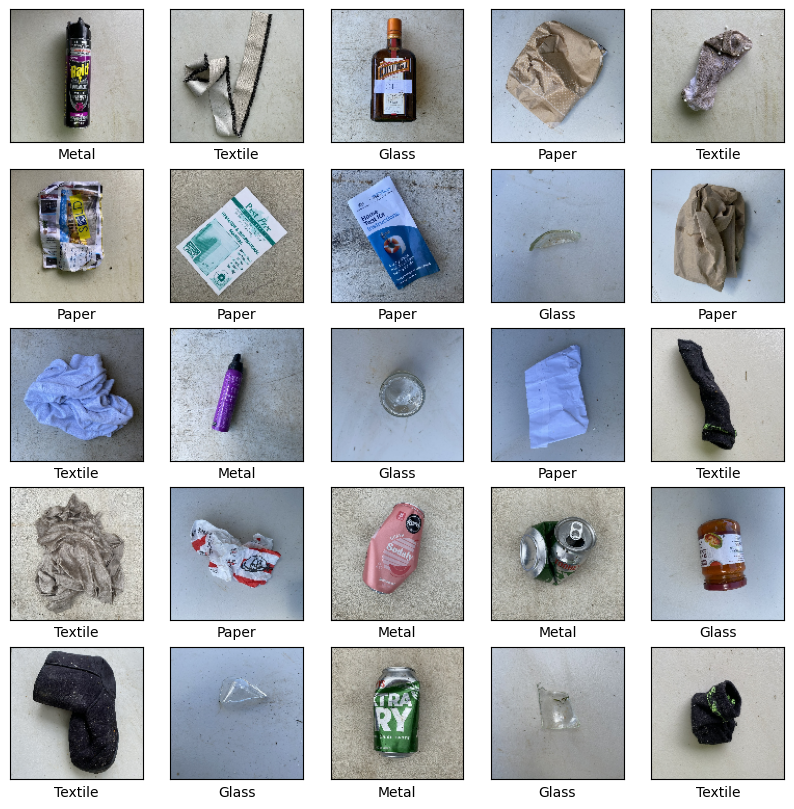

In [10]:
#Display 25 images 
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [11]:
#Sequential Model 1
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Input((128, 128 ,3)),
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation='softmax')
       
])

model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 62, 62, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 31, 31, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 31, 31, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 61504)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       7,872,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,892,548 (30.11 MB)

 Trainable params: 7,892,548 (30.11 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
#Sequential Model 2 with image size 128, 128, 3
model_2 = tf.keras.models.Sequential([
    tf.keras.layers.Input((128,128,3)),
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
       
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation='softmax')
])
model_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 16, 16, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         524,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 691,972 (2.64 MB)

 Trainable params: 691,972 (2.64 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
#Sequential Model 3 
# Build a deep model 
model_3 = tf.keras.models.Sequential([
    tf.keras.layers.Input((128,128,3)),
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(64, (5,5), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation='softmax')
       
])

model_3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 64, 64, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 16, 16, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 8, 8, 32)            │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 4, 4, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 4, 4, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 284,452 (1.09 MB)

 Trainable params: 284,452 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Add callbacks to save the model weight with best accuracy during training
# import ModelCheckpoint package
# from tensorflow.keras.callbacks import ModelCheckpoint
# Source: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

checkpoint_filepath1 = 'C:/Mani/ModelCheckpoint/model1.keras'
model_checkpoint_callback1 = ModelCheckpoint(
    filepath=checkpoint_filepath1,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)


checkpoint_filepath2 = 'C:/Mani/ModelCheckpoint/model2.keras'
model_checkpoint_callback2 = ModelCheckpoint(
    filepath=checkpoint_filepath2,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

checkpoint_filepath3 = 'C:/Mani/ModelCheckpoint/model3.keras'
model_checkpoint_callback3 = ModelCheckpoint(
    filepath=checkpoint_filepath3,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)


In [15]:
model_1.compile(optimizer = tf.keras.optimizers.Adam(1e-3),
                loss = 'sparse_categorical_crossentropy', 
                metrics=['accuracy'])


model_2.compile(optimizer = tf.keras.optimizers.Adam(1e-3),
                loss = 'sparse_categorical_crossentropy',
                metrics=['accuracy'])


model_3.compile(optimizer = tf.keras.optimizers.Adam(1e-3),
                loss = 'sparse_categorical_crossentropy',
                metrics=['accuracy'])
               

In [16]:
# Set number of epochs
epochs = 100
batch_size = 32



In [17]:
#Model 1 training
# Get the current time
start_time = datetime.now()
print('Time model start:', start_time)

history1 = model_1.fit(train_images, train_labels,
                       batch_size=batch_size, epochs=epochs,
                       validation_split = 0.2, verbose=1,
                       callbacks=[model_checkpoint_callback1]) 

# Get the current time
end_time = datetime.now()
print('Time model end:', end_time) 
print('Model_1_training_time', end_time - start_time )

Time model start: 2024-11-07 11:57:26.912405
Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.2680 - loss: 4.1535
Epoch 1: val_accuracy improved from -inf to 0.25000, saving model to C:/Mani/ModelCheckpoint/model1.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 289ms/step - accuracy: 0.2677 - loss: 4.0952 - val_accuracy: 0.2500 - val_loss: 1.3790
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.3231 - loss: 1.3315
Epoch 2: val_accuracy improved from 0.25000 to 0.51389, saving model to C:/Mani/ModelCheckpoint/model1.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 278ms/step - accuracy: 0.3249 - loss: 1.3302 - val_accuracy: 0.5139 - val_loss: 1.2382
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.5096 - loss: 1.0978
Epoch 3: val_accuracy improved from 0.51389 to 0.56481, saving model to C:/Mani/ModelCheckpoint/model1.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 277ms/step - accuracy: 0.5104 - loss: 1.0972 - val_accuracy: 0.5648 - val_loss: 1.1386
Epoch 4/100
27/27 ━

Epoch 25/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.9933 - loss: 0.0357
Epoch 25: val_accuracy did not improve from 0.67593
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 260ms/step - accuracy: 0.9932 - loss: 0.0360 - val_accuracy: 0.6435 - val_loss: 1.7483
Epoch 26/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.9858 - loss: 0.0421
Epoch 26: val_accuracy did not improve from 0.67593
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 252ms/step - accuracy: 0.9858 - loss: 0.0422 - val_accuracy: 0.6157 - val_loss: 1.7438
Epoch 27/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.9882 - loss: 0.0549
Epoch 27: val_accuracy did not improve from 0.67593
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 256ms/step - accuracy: 0.9881 - loss: 0.0550 - val_accuracy: 0.6574 - val_loss: 1.5827
Epoch 28/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.9936 - loss: 0.0368
Epoch 28: val_accuracy did not improve from 0.67593
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 262ms/step - accuracy: 0.9937 - loss: 0.0364 - val_accuracy

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 1.0000 - loss: 0.0018
Epoch 50: val_accuracy did not improve from 0.67593
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 266ms/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 0.6528 - val_loss: 2.3847
Epoch 51/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 1.0000 - loss: 8.3126e-04
Epoch 51: val_accuracy did not improve from 0.67593
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 269ms/step - accuracy: 1.0000 - loss: 8.3538e-04 - val_accuracy: 0.6481 - val_loss: 2.4749
Epoch 52/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.9996 - loss: 0.0019
Epoch 52: val_accuracy did not improve from 0.67593
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 274ms/step - accuracy: 0.9995 - loss: 0.0020 - val_accuracy: 0.6435 - val_loss: 2.5845
Epoch 53/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.9986 - loss: 0.0039
Epoch 53: val_accuracy did not improve from 0.67593
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 279ms/step - accuracy: 0.9985 - loss: 0.0042 - val_accuracy: 0.6

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.9999 - loss: 0.0018
Epoch 75: val_accuracy did not improve from 0.67593
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 246ms/step - accuracy: 0.9998 - loss: 0.0019 - val_accuracy: 0.6065 - val_loss: 2.4606
Epoch 76/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.9961 - loss: 0.0070
Epoch 76: val_accuracy did not improve from 0.67593
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 249ms/step - accuracy: 0.9962 - loss: 0.0069 - val_accuracy: 0.6204 - val_loss: 2.4043
Epoch 77/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 1.0000 - loss: 0.0016
Epoch 77: val_accuracy did not improve from 0.67593
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 249ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 0.6204 - val_loss: 2.7740
Epoch 78/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 1.0000 - loss: 0.0011
Epoch 78: val_accuracy did not improve from 0.67593
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 247ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.6111 - va

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.9939 - loss: 0.0337
Epoch 100: val_accuracy did not improve from 0.67593
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 248ms/step - accuracy: 0.9940 - loss: 0.0331 - val_accuracy: 0.6250 - val_loss: 2.8182
Time model end: 2024-11-07 12:09:21.369959
Model_1_training_time 0:11:54.457554


In [18]:
# Model 2 training
# Get the current time
start_time = datetime.now()
print('Time model start:', start_time)


history2 = model_2.fit(train_images, train_labels,
                       batch_size=batch_size, epochs= epochs, 
                       validation_split = 0.2, verbose=1,
                       callbacks=[model_checkpoint_callback2])

# Get the current time
end_time = datetime.now()
print('Time model end:', end_time) 
print('Model_2_training_time', end_time - start_time )

Time model start: 2024-11-07 12:09:21.377658
Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.2632 - loss: 1.4357
Epoch 1: val_accuracy improved from -inf to 0.23148, saving model to C:/Mani/ModelCheckpoint/model2.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 299ms/step - accuracy: 0.2633 - loss: 1.4346 - val_accuracy: 0.2315 - val_loss: 1.3844
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.3037 - loss: 1.3678
Epoch 2: val_accuracy improved from 0.23148 to 0.32870, saving model to C:/Mani/ModelCheckpoint/model2.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 291ms/step - accuracy: 0.3045 - loss: 1.3675 - val_accuracy: 0.3287 - val_loss: 1.3358
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.3903 - loss: 1.2709
Epoch 3: val_accuracy improved from 0.32870 to 0.54167, saving model to C:/Mani/ModelCheckpoint/model2.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 289ms/step - accuracy: 0.3924 - loss: 1.2688 - val_accuracy: 0.5417 - val_loss: 1.1449
Epoch 4/100
27/27 

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.9679 - loss: 0.1010
Epoch 24: val_accuracy improved from 0.78704 to 0.80556, saving model to C:/Mani/ModelCheckpoint/model2.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 287ms/step - accuracy: 0.9678 - loss: 0.1011 - val_accuracy: 0.8056 - val_loss: 0.6531
Epoch 25/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.9684 - loss: 0.0900
Epoch 25: val_accuracy improved from 0.80556 to 0.82407, saving model to C:/Mani/ModelCheckpoint/model2.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 286ms/step - accuracy: 0.9679 - loss: 0.0907 - val_accuracy: 0.8241 - val_loss: 0.6066
Epoch 26/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.9490 - loss: 0.1317
Epoch 26: val_accuracy did not improve from 0.82407
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 291ms/step - accuracy: 0.9491 - loss: 0.1319 - val_accuracy: 0.7639 - val_loss: 0.7429
Epoch 27/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.9396 - loss: 0.1533
Epoch 27: val_accuracy did not improve

Epoch 49/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.9882 - loss: 0.0314
Epoch 49: val_accuracy did not improve from 0.82870
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 284ms/step - accuracy: 0.9881 - loss: 0.0317 - val_accuracy: 0.8056 - val_loss: 0.7694
Epoch 50/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.9858 - loss: 0.0519
Epoch 50: val_accuracy did not improve from 0.82870
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 283ms/step - accuracy: 0.9858 - loss: 0.0517 - val_accuracy: 0.8056 - val_loss: 0.8371
Epoch 51/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.9694 - loss: 0.0856
Epoch 51: val_accuracy did not improve from 0.82870
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 282ms/step - accuracy: 0.9688 - loss: 0.0873 - val_accuracy: 0.7731 - val_loss: 0.9736
Epoch 52/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.9419 - loss: 0.1638
Epoch 52: val_accuracy did not improve from 0.82870
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 283ms/step - accuracy: 0.9421 - loss: 0.1633 - val_accuracy

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 1.0000 - loss: 0.0053
Epoch 74: val_accuracy did not improve from 0.82870
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 289ms/step - accuracy: 1.0000 - loss: 0.0053 - val_accuracy: 0.7963 - val_loss: 1.2162
Epoch 75/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 1.0000 - loss: 0.0021
Epoch 75: val_accuracy did not improve from 0.82870
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 286ms/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 0.7778 - val_loss: 1.3555
Epoch 76/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.9988 - loss: 0.0031
Epoch 76: val_accuracy did not improve from 0.82870
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 283ms/step - accuracy: 0.9988 - loss: 0.0031 - val_accuracy: 0.7963 - val_loss: 1.2593
Epoch 77/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.9947 - loss: 0.0103
Epoch 77: val_accuracy did not improve from 0.82870
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 283ms/step - accuracy: 0.9948 - loss: 0.0102 - val_accuracy: 0.8056 - va

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.9931 - loss: 0.0190
Epoch 99: val_accuracy improved from 0.83333 to 0.83796, saving model to C:/Mani/ModelCheckpoint/model2.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 287ms/step - accuracy: 0.9932 - loss: 0.0188 - val_accuracy: 0.8380 - val_loss: 0.9346
Epoch 100/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.9909 - loss: 0.0400
Epoch 100: val_accuracy did not improve from 0.83796
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 283ms/step - accuracy: 0.9906 - loss: 0.0409 - val_accuracy: 0.7500 - val_loss: 1.6959
Time model end: 2024-11-07 12:22:21.100733
Model_2_training_time 0:12:59.723075


In [19]:
#Model 3 training
# Get the current time
start_time = datetime.now()
print('Time model start:', start_time)

history3 = model_3.fit(train_images, train_labels,
                       batch_size=batch_size, epochs= epochs, 
                       validation_split = 0.2, verbose=1,
                       callbacks=[model_checkpoint_callback3])

# Get the current time
end_time = datetime.now()
print('Time model end:', end_time) 
print('Model_3_training_time', end_time - start_time )

Time model start: 2024-11-07 12:22:21.108138
Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.2680 - loss: 1.4030
Epoch 1: val_accuracy improved from -inf to 0.30093, saving model to C:/Mani/ModelCheckpoint/model3.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 387ms/step - accuracy: 0.2683 - loss: 1.4026 - val_accuracy: 0.3009 - val_loss: 1.3832
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.2613 - loss: 1.3797
Epoch 2: val_accuracy improved from 0.30093 to 0.43519, saving model to C:/Mani/ModelCheckpoint/model3.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 410ms/step - accuracy: 0.2627 - loss: 1.3790 - val_accuracy: 0.4352 - val_loss: 1.3262
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.4439 - loss: 1.2599
Epoch 3: val_accuracy improved from 0.43519 to 0.48148, saving model to C:/Mani/ModelCheckpoint/model3.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 404ms/step - accuracy: 0.4434 - loss: 1.2592 - val_accuracy: 0.4815 - val_loss: 1.1619
Epoch 4/100
27/2

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - accuracy: 0.8536 - loss: 0.3947
Epoch 24: val_accuracy did not improve from 0.81481
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 403ms/step - accuracy: 0.8540 - loss: 0.3937 - val_accuracy: 0.7731 - val_loss: 0.5394
Epoch 25/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.8310 - loss: 0.4079
Epoch 25: val_accuracy did not improve from 0.81481
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 395ms/step - accuracy: 0.8313 - loss: 0.4080 - val_accuracy: 0.7870 - val_loss: 0.5697
Epoch 26/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.8701 - loss: 0.3637
Epoch 26: val_accuracy did not improve from 0.81481
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 400ms/step - accuracy: 0.8698 - loss: 0.3635 - val_accuracy: 0.7963 - val_loss: 0.5278
Epoch 27/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.8632 - loss: 0.3322
Epoch 27: val_accuracy did not improve from 0.81481
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 404ms/step - accuracy: 0.8635 - loss: 0.3319 - val_accuracy: 0.7685 

Epoch 49/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.9804 - loss: 0.0758
Epoch 49: val_accuracy did not improve from 0.83333
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 409ms/step - accuracy: 0.9803 - loss: 0.0758 - val_accuracy: 0.8102 - val_loss: 0.6195
Epoch 50/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.9665 - loss: 0.0965
Epoch 50: val_accuracy did not improve from 0.83333
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 402ms/step - accuracy: 0.9663 - loss: 0.0974 - val_accuracy: 0.7870 - val_loss: 0.7402
Epoch 51/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.9322 - loss: 0.2073
Epoch 51: val_accuracy did not improve from 0.83333
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 395ms/step - accuracy: 0.9315 - loss: 0.2085 - val_accuracy: 0.7685 - val_loss: 0.6867
Epoch 52/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.9224 - loss: 0.2312
Epoch 52: val_accuracy did not improve from 0.83333
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 396ms/step - accuracy: 0.9228 - loss: 0.2298 - val_accu

Epoch 74/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.9658 - loss: 0.0905
Epoch 74: val_accuracy did not improve from 0.85648
27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 373ms/step - accuracy: 0.9662 - loss: 0.0896 - val_accuracy: 0.8102 - val_loss: 0.6827
Epoch 75/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.9864 - loss: 0.0482
Epoch 75: val_accuracy did not improve from 0.85648
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 370ms/step - accuracy: 0.9862 - loss: 0.0485 - val_accuracy: 0.8102 - val_loss: 0.7025
Epoch 76/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.9658 - loss: 0.0825
Epoch 76: val_accuracy did not improve from 0.85648
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 376ms/step - accuracy: 0.9660 - loss: 0.0828 - val_accuracy: 0.8380 - val_loss: 0.6892
Epoch 77/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - accuracy: 0.9822 - loss: 0.0587
Epoch 77: val_accuracy did not improve from 0.85648
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 401ms/step - accuracy: 0.9818 - loss: 0.0591 - val_accu

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.9920 - loss: 0.0275
Epoch 99: val_accuracy did not improve from 0.85648
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 396ms/step - accuracy: 0.9920 - loss: 0.0274 - val_accuracy: 0.8194 - val_loss: 0.8540
Epoch 100/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - accuracy: 0.9934 - loss: 0.0205
Epoch 100: val_accuracy did not improve from 0.85648
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 398ms/step - accuracy: 0.9933 - loss: 0.0209 - val_accuracy: 0.8333 - val_loss: 0.8111
Time model end: 2024-11-07 12:40:56.560015
Model_3_training_time 0:18:35.451877


Text(0.5, 1.0, 'Model_1 Accuracy (Exp:1.5)')

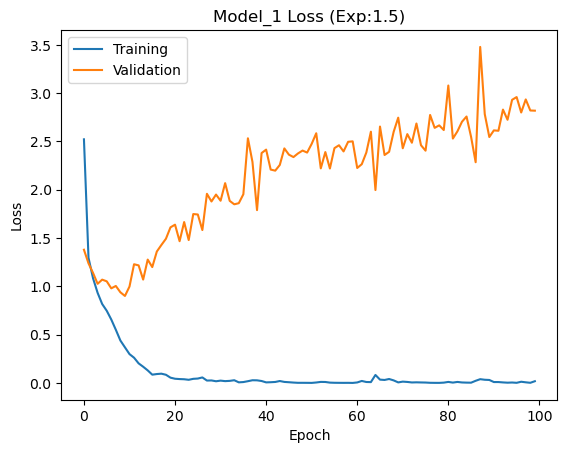

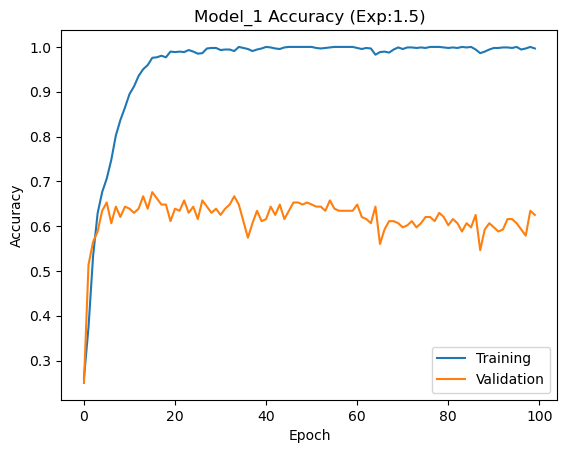

In [20]:

#Plot the training and validation loss
plt.figure()
plt.plot(history1.history['loss'], label='Training')
plt.plot(history1.history['val_loss'], label='Validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model_1 Loss (Exp:1.5)')

#Plot the training and validation Accuracy
plt.figure()
plt.plot(history1.history['accuracy'], label='Training')
plt.plot(history1.history['val_accuracy'], label='Validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model_1 Accuracy (Exp:1.5)')


Text(0.5, 1.0, 'Model_2 Accuracy (Exp:1.5)')

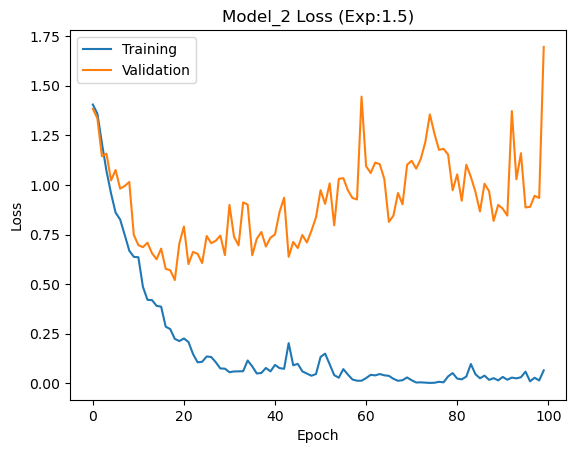

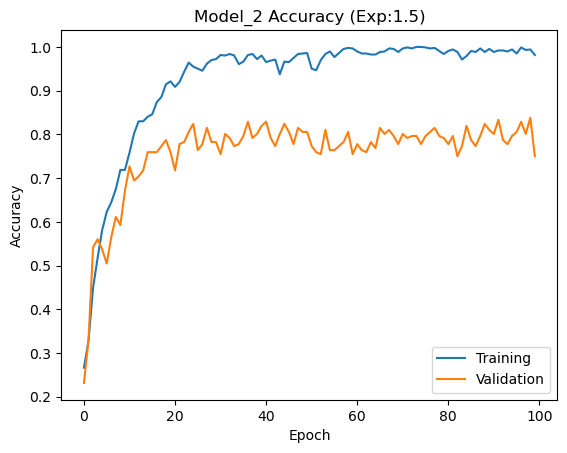

In [21]:
#Plot the training and validation loss
plt.figure()
plt.plot(history2.history['loss'], label='Training')
plt.plot(history2.history['val_loss'], label='Validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model_2 Loss (Exp:1.5)')

#Plot the training and validation Accuracy
plt.figure()
plt.plot(history2.history['accuracy'], label='Training')
plt.plot(history2.history['val_accuracy'], label='Validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model_2 Accuracy (Exp:1.5)')

Text(0.5, 1.0, 'Model_3 Accuracy (Exp:1.5)')

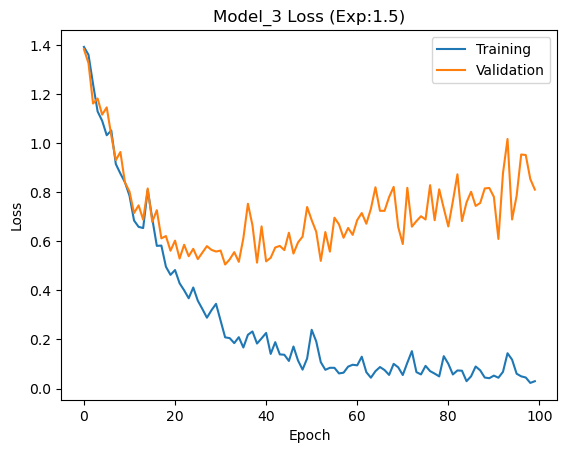

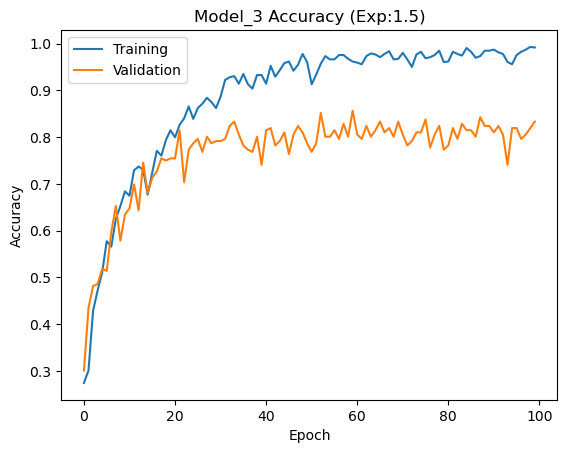

In [22]:
#Plot the training and validation loss
plt.figure()
plt.plot(history3.history['loss'], label='Training')
plt.plot(history3.history['val_loss'], label='Validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model_3 Loss (Exp:1.5)')

#Plot the training and validation Accuracy
plt.figure()
plt.plot(history3.history['accuracy'], label='Training')
plt.plot(history3.history['val_accuracy'], label='Validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model_3 Accuracy (Exp:1.5)')

In [23]:
# Evaluate the test result for model 1, 2, 3
Test_result1 = model_1.evaluate(test_images, test_labels, batch_size = 64)

Test_result2 = model_2.evaluate(test_images, test_labels, batch_size = 64)

Test_result3 = model_3.evaluate(test_images, test_labels, batch_size = 64)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.6546 - loss: 2.9878
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.7248 - loss: 2.6800 
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 0.7539 - loss: 1.3552


In [24]:
predictions1 = model_1.predict(test_images)     # Vector of probabilities
pred_label1 = np.argmax(predictions1, axis = 1) # We take the highest probability

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


In [25]:
predictions2 = model_2.predict(test_images)     # Vector of probabilities
pred_label2 = np.argmax(predictions2, axis = 1) # We take the highest probability

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step


In [26]:
predictions3 = model_3.predict(test_images)     # Vector of probabilities
pred_label3 = np.argmax(predictions3, axis = 1) # We take the highest probability

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step


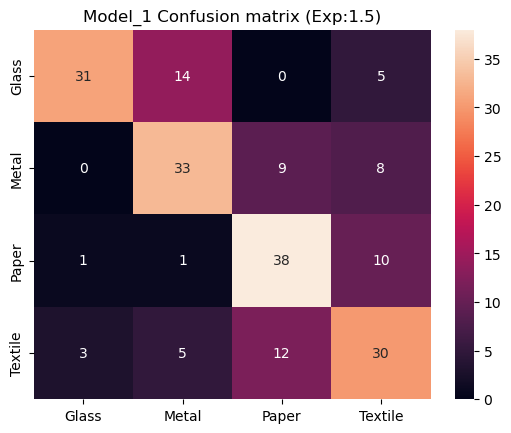

In [27]:
CM = confusion_matrix(test_labels, pred_label1)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Model_1 Confusion matrix (Exp:1.5)')
plt.show()

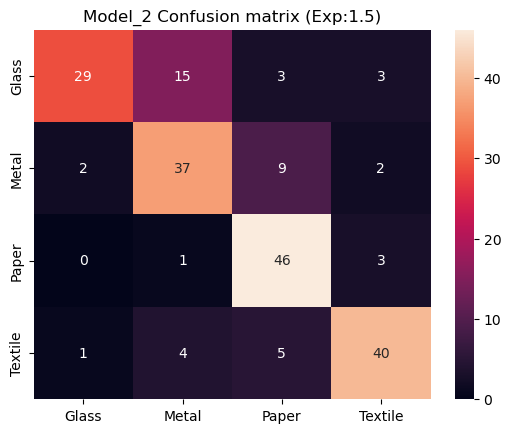

In [28]:
CM = confusion_matrix(test_labels, pred_label2)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Model_2 Confusion matrix (Exp:1.5)')
plt.show()


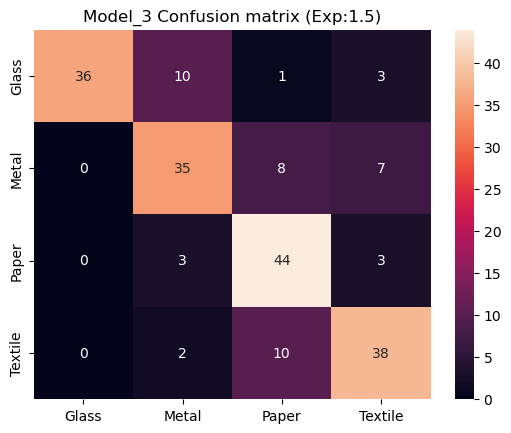

In [29]:
CM = confusion_matrix(test_labels, pred_label3)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Model_3 Confusion matrix (Exp:1.5)')
plt.show()
